# GODAS
https://catalog.pangeo.io/browse/master/ocean/GODAS/

https://www.psl.noaa.gov//data/gridded/data.godas.html

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.0b0797f2ba11480aaea85885adc06c78 Dashboard: /services/dask-gateway/clusters/prod.0b0797f2ba11480aaea85885adc06c78/status,Cluster Workers: 1 Cores: 2 Memory: 8.59 GB


In [ ]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline

In [4]:
xr.set_options(display_style='text')

In [5]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
ds = xr.open_zarr(mapping, consolidated=True)

In [6]:
ds

<xarray.Dataset>
Dimensions:    (lat: 417, lat_u: 417, level: 40, level_w: 40, lon: 360, lon_u: 360, time: 471)
Coordinates:
  * lat        (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.83 64.17 64.5
  * lat_u      (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67
  * level      (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * level_w    (level_w) float32 10.0 20.0 30.0 ... 4.225e+03 4.736e+03
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lon_u      (lon_u) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
Data variables:
    dbss_obil  (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    dbss_obml  (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    dzdt       (time, level_w, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    pottmp     (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    salt       (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    sltfl      (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    sshg       (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    thflx      (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    ucur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    uflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    vcur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    vflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
Attributes:
    Conventions:      COARDS
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    grib_file:        godas.M.198001-12.grb
    history:          Created 2006/12 by Hoop
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    title:            GODAS: Global Ocean Data Assimilation System

In [7]:
dt_values = (np.diff(ds.time) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[0:-1])}) #shaves off last time stamp in `ds.time`
ds.coords['dt'] = dt

In [8]:
#Changing longitude coords from 0:360 to -180:180
ds_roll = ds.roll(lon=-180).copy()
ds_roll_drop_lon = ds_roll.drop('lon')
lon = ds_roll.lon.data
lon[lon>180.] -= 360.
ds_roll_drop_lon.coords['lon'] = ('lon', lon)
ds_roll_drop_lon.lon

ds_roll_u = ds_roll_drop_lon.roll(lon_u=-180).copy()
ds_roll_drop_lon_u = ds_roll_u.drop('lon_u')
lon_u = ds_roll_u.lon_u.data
lon_u[lon_u>180.] -= 360.
ds_roll_drop_lon_u.coords['lon_u'] = ('lon_u', lon_u)

<ipython-input-8-faf756f2a2d8>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll = ds.roll(lon=-180).copy()
<ipython-input-8-faf756f2a2d8>:9: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll_u = ds_roll_drop_lon.roll(lon_u=-180).copy()


In [9]:
coords = ds_roll_drop_lon_u.coords.to_dataset().reset_coords()
ds = ds_roll_drop_lon_u.reset_coords(drop=True)

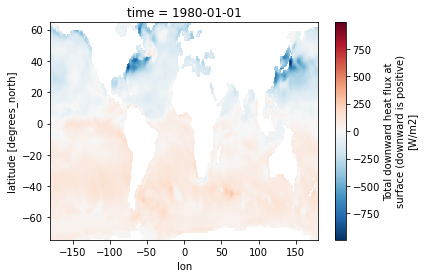

In [10]:
ds.thflx[0].plot()

#### What can we compute with GODAS ds?
- [ ] surf flux
- [ ] in/outflow i.e transport at boundaries
- [ ] residual (consists of diff fluxes, numerical and discretization residuals)
- [ ] total tendency

## <font color='Green'>Get cell area and volume in meters</font>

In [11]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [12]:
#converting degrees lat to lat [meters]
delta_lat = coords.lat.diff('lat')
dy = delta_lat * meters_per_degree
delta_lat_u = coords.lat_u.diff('lat_u')
dy_u = delta_lat_u * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = coords.lon.diff('lon')
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(coords.lat))
delta_lon_u = coords.lon_u.diff('lon_u')
dx_u = delta_lon_u * meters_per_degree * np.cos(np.deg2rad(coords.lat_u))

In [13]:
dx = dx[:, 1:]
dx_u = dx_u[:, 1:]

In [14]:
dz = coords.level.diff('level')

In [15]:
cell_area = dx * dy
cell_volume = dx * dy * dz
cell_area_u = dx_u * dy_u
cell_volume_u = dx_u * dy_u * dz

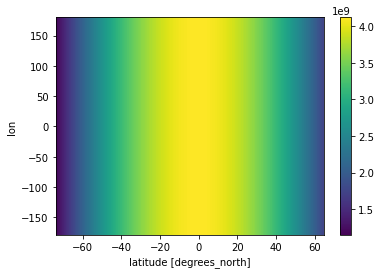

In [16]:
cell_area.plot()

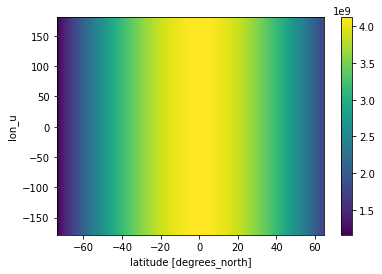

In [17]:
cell_area_u.plot()

## <font color='Green'>\begin{equation*} Set\ to\ WG,\ create\ grid \end{equation*}</font>

In [18]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-74.16667˚S
upper_lat = 37 #-61.83˚S
left_lon =  114 #65.5˚W
right_lon = 210 #30.5˚E

lower_lat_u = 0 #-74.0
upper_lat_u = 37 #-61.67 python is left exclusive so will have -62.0 in array
left_lon_u = 114 #65.0˚W 
right_lon_u = 210 #31.0˚E python is left exclusive so will have 30.0˚E

In [19]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat), lat_u=slice(lower_lat_u, upper_lat_u))
lon_range = dict(lon=slice(left_lon, right_lon), lon_u=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(lat=slice(lower_lat, upper_lat))
lon_range_no_u = dict(lon=slice(left_lon, right_lon))

lat_range_u = dict(lat_u=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(lon_u=slice(left_lon_u, right_lon_u))

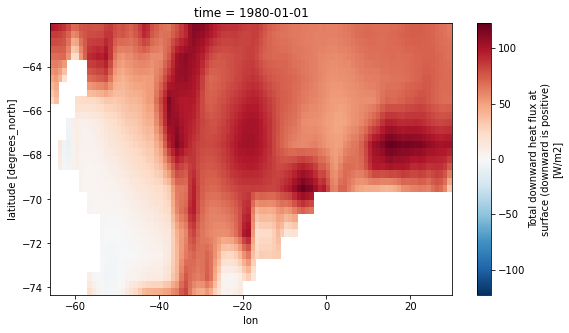

In [20]:
ds.thflx[0].isel(**lat_range_no_u, **lon_range_no_u).plot(figsize=(9,5))

In [21]:
ds_wg = ds.isel(**lat_range, **lon_range)
coords_wg = coords.isel(**lat_range, **lon_range)

cell_area_wg = cell_area.isel(**lat_range_no_u, **lon_range_no_u)
cell_volume_wg = cell_volume.isel(**lat_range_no_u, **lon_range_no_u)

cell_area_u_wg = cell_area_u.isel(**lat_range_u, **lon_range_u)
cell_volume_u_wg = cell_volume_u.isel(**lat_range_u, **lon_range_u)

In [22]:
dx_wg = dx.isel(**lon_range_no_u, **lat_range_no_u)
dx_u_wg = dx_u.isel(**lon_range_u, **lat_range_u)

dy_wg = dy.isel(**lat_range_no_u)
dy_u_wg = dy_u.isel(**lat_range_u)

1. interpolate temp onto psi_vel terms
2. rhs = surf + vel
3. lhs = total_tend
4. lhs = rhs

In [23]:
import xgcm
grid = xgcm.Grid(ds_wg, coords={'X': {'center': 'lon', 'right': 'lon_u'}, 
                                'Y': {'center': 'lat', 'right': 'lat_u'},
                                'T': {'center': 'time'},
                                'Z': {'center': 'level', 'right': 'level_w'}},
                        periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> right
  * right    lon_u --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> right
  * right    lat_u --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   level --> right
  * right    level_w --> center

In [47]:
temp = ds_wg.pottmp - 273.15 #K to C
salt = ds_wg.salt * 1000 #kg/kg to g/kg

## <font color='Green'>\begin{equation*} Surface\ Fluxes \end{equation*}</font>

In [24]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = (ds_wg.thflx[:, 1:, 1:] * cell_area_wg) / (heat_capacity_cp * runit2mass) #˚C*m^3/s
surf_flux_slt = (ds_wg.sltfl[:, 1:, 1:] * cell_area_wg * 1e4) / runit2mass # psu*m^3/s

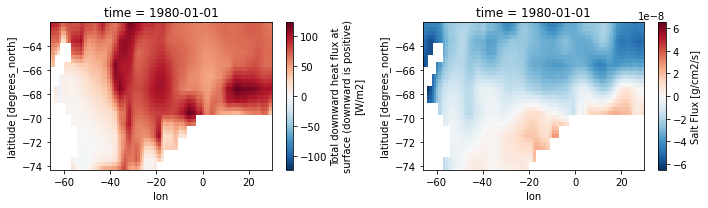

In [25]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
ds_wg.thflx[0].plot(ax=ax0)
ds_wg.sltfl[0].plot(ax=ax1)
plt.tight_layout();

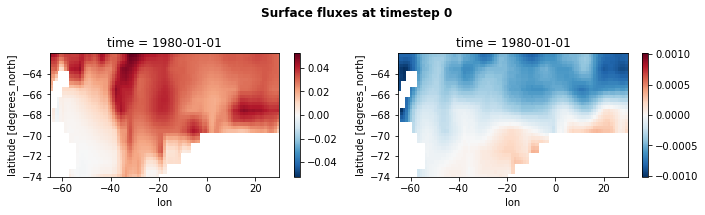

In [26]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th[0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt[0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Surface fluxes at timestep 0', fontweight='bold')
plt.tight_layout();

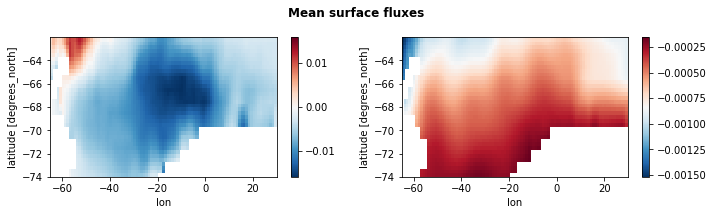

In [27]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

In [34]:
def surface_to_3d(da):
    da = da.copy()
    da.coords['level'] = ds_wg.level[0]
    da = da.expand_dims(dim='level', axis=1)
    da, _ = xr.align(da, coords.level, join='right')
    return da.fillna(0.)

In [35]:
surf_flux_th

<xarray.DataArray (time: 471, lat: 36, lon: 95)>
dask.array<truediv, shape=(471, 36, 95), dtype=float32, chunksize=(12, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01

In [37]:
surf_flux_conv_TH = surface_to_3d(surf_flux_th)
surf_flux_conv_SLT = surface_to_3d(surf_flux_slt)

## <font color='Green'>\begin{equation*} \Psi_{vel}\ at\ boundary\end{equation*}</font>

In [46]:
u_transport_right = (ds_wg.ucur[:, 1:, 1:, 1:] * dy_u.isel(**lat_range_u)[:-1] * dz).isel(lon_u=-1)
u_transport_left = (ds_wg.ucur[:, 1:, 1:, 1:] * dy_u.isel(**lat_range_u)[:-1] * dz).isel(lon_u=0)

v_transport = (ds_wg.vcur[:, 1:, 1:, 1:] * dx_u.isel(**lon_range_u, **lat_range_u)[:-1, :-1] * dz).isel(lat_u=-1)
#units: m^3/s

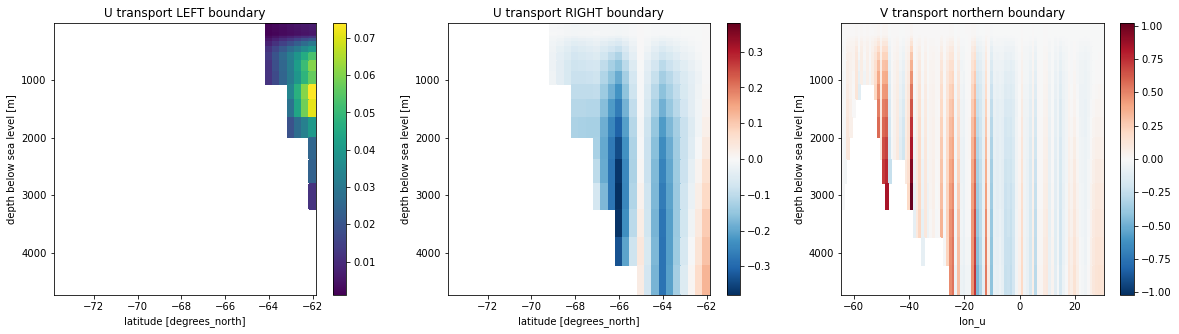

In [47]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [48]:
u_transport_mean_value = (u_transport_right.sum(dim=['lat_u', 'level']) -
                          u_transport_left.sum(dim=['lat_u', 'level'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-46.109703, dtype=float32)

In [49]:
v_transport_mean_value = (v_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(46.369274, dtype=float32)
Coordinates:
    lat_u    float32 -62.0

In [50]:
residual = u_transport_mean_value + v_transport_mean_value
residual

<xarray.DataArray ()>
array(0.25957108, dtype=float32)
Coordinates:
    lat_u    float32 -62.0

## <font color='Green'>\begin{equation*} \vec{\textbf{u}} \cdot \nabla \theta \end{equation*}</font>

## Compute conv_horiz_adv_flux

In [70]:
ucur_interp = grid.interp(ds_wg.ucur, axis=['X', 'Y'], boundary='fill', keep_coords=True)
vcur_interp = grid.interp(ds_wg.vcur, axis=['X', 'Y'], boundary='fill', keep_coords=True)

In [79]:
temp_interp_x = grid.interp(temp, 'X')
temp_interp_y = grid.interp(temp, 'Y', boundary='fill')

In [93]:
conv_horiz_adv_flux = - ((ucur_interp * grid.diff(temp_interp_x, 'X')) + (vcur_interp * grid.diff(temp_interp_y, 'Y', boundary='fill')))

In [120]:
x = ucur_interp * grid.diff(temp_interp_x, 'X')
y = vcur_interp * grid.diff(temp_interp_y, 'Y', boundary='fill')

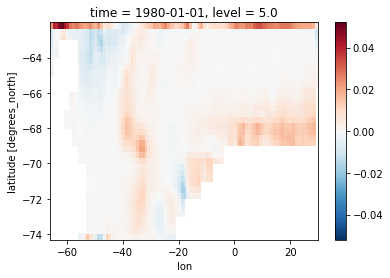

In [96]:
conv_horiz_adv_flux[0,0].plot()

In [126]:
conv_horiz_adv_flux = conv_horiz_adv_flux[:,:, 1:, 1:] * cell_area_wg[:-1, :-1] #[˚Cm^3/s]

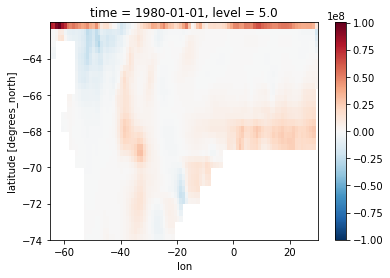

In [128]:
conv_horiz_adv_flux[0,0].plot()

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>

**Theta Tendency Term**

In [81]:
delta_theta = temp.diff('time')

In [82]:
#forcing delta_theta to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','level','lat','lon'], 
                            coords={'time': coords_wg.dt[0:-1].time.data})
delta_theta

<xarray.DataArray 'sub-d380948f6cb425aeb456b02621d06b89' (time: 470, level: 40, lat: 37, lon: 96)>
dask.array<sub, shape=(470, 40, 37, 96), dtype=float32, chunksize=(3, 40, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
Dimensions without coordinates: level, lat, lon

In [83]:
theta_tend = (delta_theta / coords.dt[0:-1])

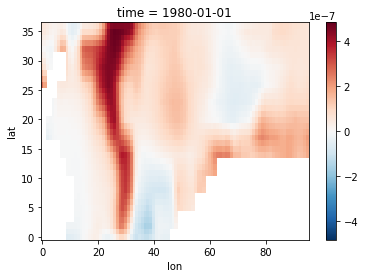

In [84]:
theta_tend[0,0].plot()

In [105]:
theta_tend[:,1:,1:,1:]

<xarray.DataArray (time: 470, level: 39, lat: 36, lon: 95)>
dask.array<getitem, shape=(470, 39, 36, 95), dtype=float32, chunksize=(3, 39, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
Dimensions without coordinates: level, lat, lon

In [106]:
totttend = theta_tend[:,1:,1:,1:] * cell_volume.isel(**lat_range_no_u, **lon_range_no_u)[:-1, :-1, :]

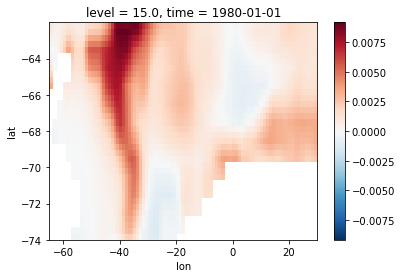

In [107]:
(totttend[0,0]/1e6).plot()

**Salt Tendency Term**

In [108]:
delta_salt = salt.diff('time')

In [109]:
#forcing delta_salt to have same timestamp as ds.dt by creating new data array called "salt_scaled"
delta_salt = xr.DataArray(delta_salt.data, dims=['time','level','lat','lon'], 
                            coords={'time': coords_wg.dt[0:-1].time.data})
delta_salt

<xarray.DataArray 'sub-20194cd5e849d258ebbf25b335f2b68f' (time: 470, level: 40, lat: 37, lon: 96)>
dask.array<sub, shape=(470, 40, 37, 96), dtype=float32, chunksize=(3, 40, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
Dimensions without coordinates: level, lat, lon

In [110]:
salt_tend = (delta_salt / coords.dt[0:-1])

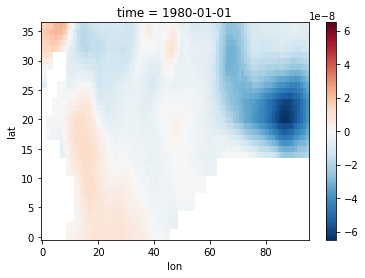

In [111]:
salt_tend[0,0].plot()

In [112]:
totstend = salt_tend[:,1:,1:,1:] * cell_volume.isel(**lat_range_no_u, **lon_range_no_u)[:-1, :-1, :]

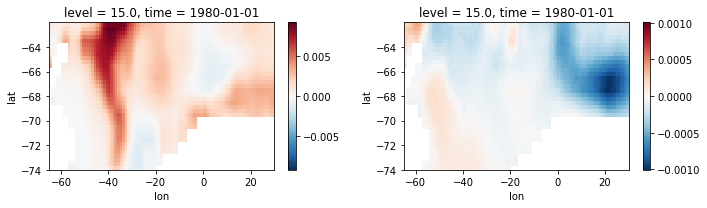

In [113]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(totstend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

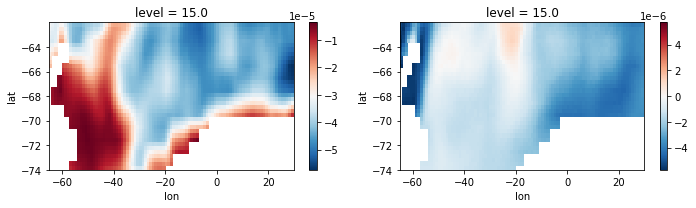

In [114]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend.isel(time=slice(0,-1), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(totstend.isel(time=slice(0,-1), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

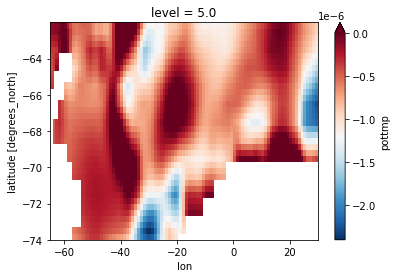

In [115]:
((temp[-3,0, 1:, 1:] - temp[0,0, 1:, 1:])/1e6).plot(cmap='RdBu_r', vmax=0)#, vmin=-6e-5)

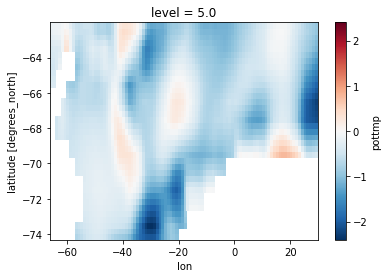

In [116]:
(temp[-3, 0] - temp[0, 0]).plot()

## Budget

In [127]:
temp_transport_north

<xarray.DataArray (time: 471, level: 39, lon_u: 95)>
dask.array<mul, shape=(471, 39, 95), dtype=float32, chunksize=(4, 39, 94), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
    lat_u    float32 -62.0
  * lon_u    (lon_u) float32 -64.0 -63.0 -62.0 -61.0 ... 27.0 28.0 29.0 30.0

In [125]:
surf_flux_th

<xarray.DataArray (time: 471, lat: 36, lon: 95)>
dask.array<truediv, shape=(471, 36, 95), dtype=float32, chunksize=(12, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01

In [124]:
surf_flux_th_interp = grid.interp(surf_flux_th, axis=['X', 'Y'], boundary='fill', keep_coords=True)
surf_flux_th_interp

ValueError: conflicting sizes for dimension 'lon_u': length 95 on the data but length 96 on coordinate 'lon_u'

In [121]:
rhs = surf_flux_th + temp_transport_right - temp_transport_left + temp_transport_north
lhs = totttend

In [122]:
rhs

<xarray.DataArray (time: 471, lat: 36, lon: 95, level: 39, lat_u: 36, lon_u: 95)>
dask.array<add, shape=(471, 36, 95, 39, 36, 95), dtype=float32, chunksize=(4, 36, 95, 39, 35, 94), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat_u    (lat_u) float32 -73.67 -73.33 -73.0 -72.67 ... -62.67 -62.33 -62.0
  * lon_u    (lon_u) float32 -64.0 -63.0 -62.0 -61.0 ... 27.0 28.0 29.0 30.0

In [119]:
lhs

<xarray.DataArray (time: 470, level: 39, lat: 36, lon: 95)>
dask.array<mul, shape=(470, 39, 36, 95), dtype=float32, chunksize=(3, 39, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float64 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

## Saving Data

In [ ]:
cell_coords_wg = xr.merge([cell_area_wg.rename('cell_area_wg'),
                       cell_area_u_wg.rename('cell_area_u_wg'),
                       cell_volume_wg.rename('cell_volume_wg'),
                       cell_volume_u_wg.rename('cell_volume_u_wg')])

In [ ]:
surf_flux = xr.merge([surf_flux_th.rename('surf_flux_th'), surf_flux_slt.rename('surf_flux_slt')])

In [ ]:
vel = xr.merge([u_transport_right.rename('u_transport_right'),
               u_transport_left.rename('u_transport_left'),
               v_transport.rename('v_transport')])

In [ ]:
total_tendency = xr.merge([totttend.chunk({'time':-1}).rename('totttend'),
                           totstend.chunk({'time':-1}).rename('totstend')])

In [ ]:
cell_elements_wg = xr.merge([dx_wg.rename('dx'), dx_u_wg.rename('dx_u'), 
                          dy_wg.rename('dy'), dy_u_wg.rename('dy_u'), 
                          dz.rename('dz')])

In [ ]:
cell_elements_wg

In [ ]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [ ]:
#saving ds_wg
gcsmap_ds_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/ds_wg.zarr')
ds_wg.to_zarr(gcsmap_ds_wg, mode='w')

In [ ]:
#saving coords_wg
gcsmap_coords_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/coords_wg.zarr')
coords_wg.to_zarr(gcsmap_coords_wg, mode='w')

In [ ]:
# saving cell_area/cell_volume
gcsmap_cell_coords_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/cell_coords_wg.zarr')
cell_coords_wg.to_zarr(gcsmap_cell_coords_wg, mode='w')

In [ ]:
# saving cell_elements
gcsmap_cell_elements = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/cell_elements_wg.zarr')
cell_elements_wg.to_zarr(gcsmap_cell_elements, mode='w')

In [ ]:
# saving surface fluxes
gcsmap_surf_flux = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/surf_flux.zarr')
surf_flux.to_zarr(gcsmap_surf_flux, mode='w')

In [ ]:
#saving transport terms
gcsmap_vel = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/vel.zarr')
vel.to_zarr(gcsmap_vel, mode='w')

In [ ]:
#saving total tendency terms
gcsmap_total_tend = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/total_tend.zarr')
total_tendency.to_zarr(gcsmap_total_tend, mode='w')